In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests 
import tarfile
from io import StringIO
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

%matplotlib inline

## Downloading the CIFAR-10 dataset

In [2]:
def download_cifar10(url):
    f = os.path.join('cifar10', "cifar-10-python.tar.gz")
    try:
        files = [
            os.path.join('cifar10', 'cifar-10-batches-py', 'meta_data'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_1'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_2'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_3'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_4'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_5'),
            os.path.join('cifar10', 'cifar-10-batches-py', 'test_batch')
        ]
        print('Checking if the following files exists\n{}\n'.format(files))
        
        assert_msg = 'Some of the files were missing'
        assert all([os.path.exists(path) for path in files]), assert_msg
    except:
        try:
            print("Extracting {}".format(f))
            filename = os.path.join('cifar10', f)
            tar = tarfile.open(f, "r:gz")
            tar.extractall('cifar10')
            tar.close()
        except FileNotFoundError:
            print("Unable to find the file {}".format(f))
            print('Downloading CIFAR-10 from {}'.format(url))
            res = requests.get(url, stream=True)
            total_length = int(res.headers.get('content-length'))
            print('Detected data size: {}KB'.format(total_length))
            print('Making a directory cifar-10 to store data')
            if not os.path.exists('cifar10'):
                os.mkdir('cifar10')
            with open(f, 'wb') as ff:
                print('Downloading data')
                for data in res.iter_content(chunk_size=1024*1024):
                    print('.',end='')
                    ff.write(data)
            
            print("Extracting {}".format(f))
            filename = os.path.join('cifar10', f)
            tar = tarfile.open(f, "r:gz")
            tar.extractall('cifar10')
            tar.close()
            
        except Exception as ex:
            print(ex)
        
    print('\n\tDone')
    
download_cifar10('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

Checking if the following files exists
['cifar10\\cifar-10-batches-py\\meta_data', 'cifar10\\cifar-10-batches-py\\data_batch_1', 'cifar10\\cifar-10-batches-py\\data_batch_2', 'cifar10\\cifar-10-batches-py\\data_batch_3', 'cifar10\\cifar-10-batches-py\\data_batch_4', 'cifar10\\cifar-10-batches-py\\data_batch_5', 'cifar10\\cifar-10-batches-py\\test_batch']

Extracting cifar10\cifar-10-python.tar.gz

	Done


## Few helper functions for processing images 
* `vec2image` - Takes in a vector of 3072 elements, reshap it to 32x32x3, subtract the mean and optionally flip the image
* `get_image` - Given a single class gets an image (for visual inspection)

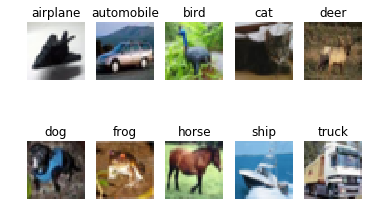

In [3]:
def vec2image(image_vec, normalize=False, global_mean=None, flip=False):
    """ Creating a 2D image from the 1D vector in the data """
    assert image_vec.size == 3072, "This (shape:{}) is not a CIFAR-10 Image".format(image_vec.shape)
    img_mat = image_vec.reshape(32,32,3, order='F')
    img_mat = np.rot90(img_mat,3)
    if normalize and global_mean:
        img_mat = img_mat.astype(np.float32) - global_mean
    if flip:
        img_mat = np.flip(img_mat, axis=1)
    return img_mat

def get_image(file, class_label):
    """ Given a class get an image """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    
    for image_vec, label in zip(dict[b"data"], dict[b"labels"]):
        if label==class_label:
            img_mat = vec2image(image_vec)
            return img_mat
        else:
            continue
    return None

def get_label_to_name_map(file):
    """ Get a list of label names in the data """
    with open(file, 'rb') as f:
        label_dict = pickle.load(f, encoding='bytes')
        return [str(v,'utf-8') for v in label_dict[b"label_names"]]
    
    return None

# file batches.meta for label to string map
label_map = get_label_to_name_map(os.path.join('cifar10', 'cifar-10-batches-py', 'batches.meta'))

plt.subplots(2,5)
for cls in range(10):
    img = get_image(
        os.path.join('cifar10', 'cifar-10-batches-py', 'data_batch_1'), cls)
    plt.subplot(2,5,cls+1)
    plt.imshow(img)
    plt.title(label_map[cls])
    plt.axis('off')

## Defining the Keras graph

In [4]:
tf.reset_default_graph()
K.clear_session()

# TODO: Define the model
model = Sequential()

# Conv1 layer (in) <= 32x32x3 / (out) => 32x32x32
model.add(layers.Conv2D(
    filters=32, kernel_size=(3,3), strides=(1,1), 
    padding="same", activation='relu')) 

# Max pooling (in) <= 32x32x32 / (out) => 16x16x32
model.add(layers.MaxPooling2D(
    pool_size=(2,2), strides=(2,2), padding="same")) 

# Conv2 layer (in) <= 16x16x32 / (out) => 16x16x64
model.add(layers.Conv2D(
    filters=64, kernel_size=(3,3), strides=(1,1),
    padding='same', activation='relu'
))

# Max pooling (in) <= 16x16x64 / (out) => 8x8x64
model.add(layers.MaxPooling2D(
    pool_size=(2,2), strides=(2,2), padding='same'
))

# Conv3 layer (in) <= 8x8x64 / (out) => 8x8x128
model.add(layers.Conv2D(
    filters=128, kernel_size=(3,3), strides=(1,1),
    padding="same", activation='relu'
))

model.add(layers.AveragePooling2D(
    pool_size=(8,8), strides=(8,8), padding="same"
))

# Unwrap the 1x1x128 tensor to a 128 vector
model.add(layers.Flatten())

# Fully conntected layer (in) <= 128 / (out) => 10
model.add(layers.Dense(10, activation='softmax'))


## Compiling the model

In [6]:
model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", metrics=['accuracy'])

## Running the model
* Using `train_on_batch` function

In [9]:
data_dir = os.path.join('cifar10','cifar-10-batches-py')
n_classes = 10
batch_size = 32

train_file_list = [
    os.path.join(data_dir, f) \
    for f in ['data_batch_1', 'data_batch_2', 
              'data_batch_3', 'data_batch_4', 'data_batch_5']
]
test_file_list = [os.path.join(data_dir, 'test_batch')]

for ep in range(20):
    losses = []
    accuracy = []
    for f in train_file_list:

        with open(f, 'rb') as fo:
            # labels, data
            dict = pickle.load(fo, encoding='bytes')
            part_vec2image = partial(
                vec2image, normalize=True, 
                global_mean=np.mean(dict[b"data"])
            )

            " Going through each batch in the data file"
            for di in range(len(dict[b"labels"])//batch_size):
                # Defining random indices
                rand_idx = np.random.randint(
                    0, len(dict[b"labels"]), batch_size
                )
            
                # Creating onehot labels from class labels
                batch_one_hot = np.zeros(
                    shape=(batch_size, n_classes))
                batch_one_hot[
                    np.arange(batch_size), 
                    np.array(dict[b"labels"])[rand_idx]
                ] = 1.0

                # Creating a batch of images
                batch_images = np.apply_along_axis(
                    part_vec2image, axis=1, arr=dict[b"data"][rand_idx,:]
                )
                
                # TODO: Save a set of normalized images

                # Training the CNN on batch of images
                model.train_on_batch(
                    batch_images, batch_one_hot)

                # TODO: Evaluate the model
                loss, acc = model.evaluate(
                    batch_images, batch_one_hot, 
                    batch_size=batch_size, verbose=0)
                
                losses.append(loss)
                accuracy.append(acc)
        print('Loss for epoch: {}'.format(np.mean(losses)))
        print('Train accuracy for epoch: {}'.format(np.mean(accuracy)))

Loss for epoch: 14.506931469990658
Train accuracy for epoch: 0.0999599358974359
Loss for epoch: 14.525496976497847
Train accuracy for epoch: 0.09880809294871795
Loss for epoch: 14.498321374257406
Train accuracy for epoch: 0.10049412393162394
Loss for epoch: 13.338090401142836
Train accuracy for epoch: 0.12697816506410256
Loss for epoch: 10.93517047999761
Train accuracy for epoch: 0.21221955128205128
Loss for epoch: 1.0393248292116017
Train accuracy for epoch: 0.6598557692307693
Loss for epoch: 0.9881309707386371
Train accuracy for epoch: 0.6770332532051282
Loss for epoch: 0.9259985843275347
Train accuracy for epoch: 0.7005208333333334
Loss for epoch: 0.8833326140466409
Train accuracy for epoch: 0.7172726362179487
Loss for epoch: 0.8451036855960503
Train accuracy for epoch: 0.7307692307692307
Loss for epoch: 0.6132514397494304
Train accuracy for epoch: 0.8182091346153846
Loss for epoch: 0.6047439421885289
Train accuracy for epoch: 0.821464342948718
Loss for epoch: 0.5831509155468044
Tra

## Running the model
* Using `fit` function with validation

In [9]:
data_dir = os.path.join('cifar10','cifar-10-batches-py')
n_classes = 10
batch_size = 32

train_file_list = [
    os.path.join(data_dir, f) \
    for f in ['data_batch_1', 'data_batch_2', 
              'data_batch_3', 'data_batch_4', 'data_batch_5']
]

test_file_list = [os.path.join(data_dir, 'test_batch')]

train_data = []
train_labels = []

for f in train_file_list:
    with open(f, 'rb') as fo:
        # labels, data
        dict = pickle.load(fo, encoding='bytes')
        part_vec2image = partial(
            vec2image, normalize=True, 
            global_mean=np.mean(dict[b"data"])
        )
        train_data.append(dict[b"data"])
        
        # One hot encoded labels
        one_hot = np.zeros(
            shape=(len(dict[b"labels"]),n_classes))
        one_hot[
            np.arange(0,len(dict[b"labels"])), 
            dict[b"labels"]] = 1.0
        train_labels.append(one_hot)
        
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
print('Train data shape: ', train_data.shape)
print('Train labels shape: ', train_labels.shape)
train_images = np.apply_along_axis(
    part_vec2image, axis=1, arr=train_data
            )
model.fit(train_images, train_labels, 
          batch_size=batch_size, validation_split=0.2, epochs=1)

Train data shape:  (50000, 3072)
Train labels shape:  (50000, 10)
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 23s 586us/step - loss: 3.2026 - acc: 0.3963 - val_loss: 1.3293 - val_acc: 0.5321


In [16]:
# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
__________

In [19]:
# Save weights
model.save_weights('cnn-cifar10.h5')

In [10]:
# Restore weights
model.load_weights('cnn-cifar10.h5')

[<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EC2EF8E278>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EC45FB19B0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EC45FB1710>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EC45FB1C88>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EC45FB1898>, <tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x000001EC45FB1518>, <tensorflow.python.keras.layers.core.Flatten object at 0x000001EC45FB1438>, <tensorflow.python.keras.layers.core.Dense object at 0x000001EC45FB1470>]
